*** Insights and analysis on the dataset from the Global Terrorism Database (GTD) maintained by the University of Maryland to know the current state of terrorism in the US, and possibly make predictions of future risks. I foresee this analysis valuable to the US Department of Homeland Security, other government establishments, businesses or individuals that care about safety of lives and properties. ***

***Dataset can be found at: http://www.start.umd.edu/gtd/***

***Goal of this project is to compare predicition accuracy based on number of classes in a target variable & predict if the nationality of an attacker's group is same as that of the attacked location***

***Overseeing Mentor: Dr. Stylianos Kampakis***

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
sns.set(style="whitegrid", color_codes=True)
np.random.seed(sum(map(ord, "categorical")))
matplotlib.style.use('ggplot')


In [2]:
%matplotlib inline

### Data wrangling and preprocessing

The dataset was downloaded as an excel spreadsheet from the GTD website, uploaded into Pandas and then we carry out some data wrangling and preprocessing.

In [3]:
file= r'C:\Users\dejavu\Desktop\git_jupyter\springboard_mini_project\capstone_projects/globalterrorismdb_0617dist.xlsx'
df= pd.read_excel(file)

In [4]:
df.shape

(170350, 135)

In [5]:
#restrict this dataset to occurrences in the US.
df1= df['country_txt'].str.contains('United States')
df2= df[df1]
df2.head(3)

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
5,197001010002,1970,1,1,NaN,0,NaT,217,United States,1,...,"The Cairo Chief of Police, William Petersen, r...","""Police Chief Quits,"" Washington Post, January...","""Cairo Police Chief Quits; Decries Local 'Mili...","Christopher Hewitt, ""Political Violence and Te...",Hewitt Project,-9,-9,0,-9,NaN
7,197001020002,1970,1,2,NaN,0,NaT,217,United States,1,...,"Damages were estimated to be between $20,000-$...",Committee on Government Operations United Stat...,"Christopher Hewitt, ""Political Violence and Te...",NaN,Hewitt Project,-9,-9,0,-9,NaN
8,197001020003,1970,1,2,NaN,0,NaT,217,United States,1,...,The New Years Gang issue a communiqué to a loc...,"Tom Bates, ""Rads: The 1970 Bombing of the Army...","David Newman, Sandra Sutherland, and Jon Stewa...","The Wisconsin Cartographers' Guild, ""Wisconsin...",Hewitt Project,0,0,0,0,NaN


In [6]:
df2.shape

(2758, 135)

In [7]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2758 entries, 5 to 169902
Columns: 135 entries, eventid to related
dtypes: datetime64[ns](1), float64(53), int64(24), object(57)
memory usage: 2.9+ MB


In [8]:
class EDA():
    '''Used for running Exploratory Data Analysis'''
    def __init__(self):
        ''''''
    def drop_col_nan(self, x, threshold):
        for col in x.columns:
            amt = sum(x[col].isnull())/float(len(x)) * 100
            if amt > threshold:
                x = x.drop(col,1)
                pd.set_option('display.max_columns', None)
        return x
        
    def drop_noisy_col(self, y, w=[]):
        y=y.drop(w, 1)
        return y
                
    def drop_col_txt(self, z):
        for c in z.columns:
            c = str(c)
            if c[-3:] =='txt':
                z = z.drop(c, 1)
                pd.set_option('display.max_columns', None)
        return z     
       

In [9]:
my_EDA = EDA()
df3=my_EDA.drop_col_nan(df2, 80)

In [10]:
df3.index = range(len(df2))

In [11]:
df4=my_EDA.drop_col_txt(df3)

In [12]:
df5=my_EDA.drop_noisy_col(df4, ['corp1', 'motive', 'target1', 'weapdetail','country','addnotes', 'summary', 'scite1' , 'scite2' , 'scite3' , 'dbsource', 'INT_LOG' ,'longitude','specificity', 'eventid', 'location','region', 'propcomment', 'latitude'])

In [13]:
df5.shape

(2758, 40)

In [14]:
df5.isnull().sum()

iyear              0
imonth             0
iday               0
extended           0
provstate          0
city               0
vicinity           0
crit1              0
crit2              0
crit3              0
doubtterr          0
multiple           0
success            0
suicide            0
attacktype1        0
targtype1          0
targsubtype1     120
natlty1            9
gname              0
guncertain1        0
individual         0
nperps           982
nperpcap        1055
claimed         1051
weaptype1          0
weapsubtype1     259
nkill             73
nkillus          953
nkillter        1004
nwound            93
nwoundus         973
nwoundte        1018
property           0
propextent      1191
propvalue       1840
ishostkid        176
ransom           588
INT_IDEO           0
INT_MISC           0
INT_ANY            0
dtype: int64

In [15]:
df5.dtypes

iyear             int64
imonth            int64
iday              int64
extended          int64
provstate        object
city             object
vicinity          int64
crit1             int64
crit2             int64
crit3             int64
doubtterr         int64
multiple          int64
success           int64
suicide           int64
attacktype1       int64
targtype1         int64
targsubtype1    float64
natlty1         float64
gname            object
guncertain1     float64
individual        int64
nperps          float64
nperpcap        float64
claimed         float64
weaptype1         int64
weapsubtype1    float64
nkill           float64
nkillus         float64
nkillter        float64
nwound          float64
nwoundus        float64
nwoundte        float64
property          int64
propextent      float64
propvalue       float64
ishostkid       float64
ransom          float64
INT_IDEO          int64
INT_MISC          int64
INT_ANY           int64
dtype: object

***Exporting the DataFrame to Excel for more analysis***

In [16]:
#writer = pd.ExcelWriter('abc2_xlsx', engine='xlsxwriter')
#df5.to_excel(writer, sheet_name='Sheet1')
#writer.save()

***Imputing Missing Values***

In [17]:
from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.
        Columns of dtype object are imputed with the most frequent value 
        in column.
        Columns of other types are imputed with median of column.
        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index=X.columns)
        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [18]:
df6 = DataFrameImputer().fit_transform(df5)
df6.head()

,iyear,imonth,iday,extended,provstate,city,vicinity,crit1,crit2,crit3,doubtterr,multiple,success,suicide,attacktype1,targtype1,targsubtype1,natlty1,gname,guncertain1,individual,nperps,nperpcap,claimed,weaptype1,weapsubtype1,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propvalue,ishostkid,ransom,INT_IDEO,INT_MISC,INT_ANY
0,1970,1,1,0,Illinois,Cairo,0,1,1,1,0,0,1,0,2,3,22.0,217.0,Black Nationalists,0.0,0,-99.0,-99.0,0.0,5,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3.0,5000.0,0.0,0.0,-9,0,-9
1,1970,1,2,0,California,Oakland,0,1,1,1,1,0,1,0,3,21,107.0,217.0,Unknown,0.0,0,-99.0,-99.0,0.0,6,16.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3.0,22500.0,0.0,0.0,-9,0,-9
2,1970,1,2,0,Wisconsin,Madison,0,1,1,1,0,0,1,0,7,4,28.0,217.0,New Year's Gang,0.0,0,1.0,1.0,1.0,8,19.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3.0,60000.0,0.0,0.0,0,0,0
3,1970,1,3,0,Wisconsin,Madison,0,1,1,1,0,0,1,0,7,2,21.0,217.0,New Year's Gang,0.0,0,1.0,1.0,0.0,8,20.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3.0,5000.0,0.0,0.0,0,0,0
4,1970,1,1,0,Wisconsin,Baraboo,0,1,1,0,1,0,0,0,3,4,27.0,217.0,"Weather Underground, Weathermen",0.0,0,-99.0,-99.0,0.0,6,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3.0,0.0,0.0,0.0,0,0,0


** Removing the unknowns from group name (gname) column**

In [19]:
df8 = df6[df6['gname'] != 'Unknown']

In [20]:
df8.shape

(2206, 40)

**Reseting the Index**


In [21]:
df9 = df8.reset_index(drop=True)
df9.head()

,iyear,imonth,iday,extended,provstate,city,vicinity,crit1,crit2,crit3,doubtterr,multiple,success,suicide,attacktype1,targtype1,targsubtype1,natlty1,gname,guncertain1,individual,nperps,nperpcap,claimed,weaptype1,weapsubtype1,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propvalue,ishostkid,ransom,INT_IDEO,INT_MISC,INT_ANY
0,1970,1,1,0,Illinois,Cairo,0,1,1,1,0,0,1,0,2,3,22.0,217.0,Black Nationalists,0.0,0,-99.0,-99.0,0.0,5,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3.0,5000.0,0.0,0.0,-9,0,-9
1,1970,1,2,0,Wisconsin,Madison,0,1,1,1,0,0,1,0,7,4,28.0,217.0,New Year's Gang,0.0,0,1.0,1.0,1.0,8,19.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3.0,60000.0,0.0,0.0,0,0,0
2,1970,1,3,0,Wisconsin,Madison,0,1,1,1,0,0,1,0,7,2,21.0,217.0,New Year's Gang,0.0,0,1.0,1.0,0.0,8,20.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3.0,5000.0,0.0,0.0,0,0,0
3,1970,1,1,0,Wisconsin,Baraboo,0,1,1,0,1,0,0,0,3,4,27.0,217.0,"Weather Underground, Weathermen",0.0,0,-99.0,-99.0,0.0,6,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3.0,0.0,0.0,0.0,0,0,0
4,1970,1,6,0,Colorado,Denver,0,1,1,1,1,0,1,0,7,4,28.0,217.0,Left-Wing Militants,0.0,0,-99.0,-99.0,0.0,8,19.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3.0,305.0,0.0,0.0,-9,0,-9


***Encoding objects into categorical variables, since scikit-learn requires that all cells be numeric (int or float etc)***

In [22]:
from sklearn.preprocessing import LabelEncoder
var_mod = ['gname', 'provstate', 'city']
le = LabelEncoder()
for i in var_mod:
    df9[i] = le.fit_transform(df9[i])

*** Descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution after excluding NaN values.***

In [23]:
df9.describe()

,iyear,imonth,iday,extended,provstate,city,vicinity,crit1,crit2,crit3,doubtterr,multiple,success,suicide,attacktype1,targtype1,targsubtype1,natlty1,gname,guncertain1,individual,nperps,nperpcap,claimed,weaptype1,weapsubtype1,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propvalue,ishostkid,ransom,INT_IDEO,INT_MISC,INT_ANY
count,2206.000000,2206.000000,2206.000000,2206.000000,2206.000000,2206.000000,2206.000000,2206.000000,2206.000000,2206.000000,2206.000000,2206.000000,2206.000000,2206.000000,2206.000000,2206.000000,2206.000000,2206.000000,2206.000000,2206.000000,2206.000000,2206.000000,2206.000000,2206.000000,2206.000000,2206.000000,2206.000000,2206.000000,2206.000000,2206.000000,2206.000000,2206.000000,2206.000000,2206.000000,2.206000e+03,2206.000000,2206.000000,2206.000000,2206.000000,2206.000000
mean,1981.915231,6.273345,15.424751,0.004080,23.189937,315.547144,0.014959,0.993200,0.974615,0.988667,0.033092,0.174071,0.831369,0.003173,4.236627,5.850408,34.859021,212.775159,102.345875,0.104261,0.088849,-66.985494,-71.115594,0.043518,6.657752,15.400725,1.620127,1.532638,0.025385,8.056664,1.035811,0.012693,0.341795,3.076156,3.882646e+05,0.024932,0.003173,-3.130553,0.079782,-2.998640
std,12.528338,3.428451,9.165770,0.063757,15.364556,156.673424,0.121417,0.082198,0.157328,0.105874,0.985285,0.379256,0.374511,0.056254,2.092041,5.485856,27.071612,38.482841,66.246551,0.305668,0.284590,47.368165,45.019500,1.309623,1.550744,5.961546,41.983344,40.741490,0.250694,222.774358,21.368213,0.164468,2.025494,0.346806,1.393189e+07,0.155953,0.056254,4.540291,0.486534,4.585247
min,1970.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,8.000000,0.000000,0.000000,0.000000,-99.000000,-99.000000,-9.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9.000000,1.000000,-9.900000e+01,0.000000,0.000000,-9.000000,-9.000000,-9.000000
25%,1971.000000,3.000000,7.000000,0.000000,6.000000,178.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,3.000000,1.000000,11.000000,217.000000,48.000000,0.000000,0.000000,-99.000000,-99.000000,0.000000,6.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,5.000000e+03,0.000000,0.000000,-9.000000,0.000000,-9.000000
50%,1977.000000,6.000000,15.000000,0.000000,27.000000,359.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,3.000000,4.000000,28.000000,217.000000,105.000000,0.000000,0.000000,-99.000000,-99.000000,0.000000,6.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,5.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1988.000000,9.000000,23.000000,0.000000,35.000000,454.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,7.000000,8.000000,49.000000,217.000000,145.000000,0.000000,0.000000,1.000000,0.000000,0.000000,8.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,5.000000e+03,0.000000,0.000000,0.000000,0.000000,1.000000
max,2016.000000,12.000000,31.000000,1.000000,52.000000,591.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.000000,22.000000,110.000000,422.000000,227.000000,1.000000,1.000000,200.000000,11.000000,1.000000,13.000000,30.000000,1383.000000,1358.000000,5.000000,7366.000000,751.000000,4.000000,1.000000,4.000000,6.520000e+08,1.000000,1.000000,1.000000,1.000000,1.000000


From the discriptive statistics above, one can tell the following:
1. if the distribution of each each feature or predictor is skewed by comparing the mean to the median (50% mark). 
2. skewedness from #1 if any translates to some outliers in the distribution.
3. the distribution of the datapoints. The greater the standard deviation ('std'), the more dispersed the datapoints are.

One can delve deeper into each feature using scatterplots and barcharts or histogram depending on the algorithm you intend using. However, it is not really necessary for my analysis 

In [24]:
df9.head()

,iyear,imonth,iday,extended,provstate,city,vicinity,crit1,crit2,crit3,doubtterr,multiple,success,suicide,attacktype1,targtype1,targsubtype1,natlty1,gname,guncertain1,individual,nperps,nperpcap,claimed,weaptype1,weapsubtype1,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propvalue,ishostkid,ransom,INT_IDEO,INT_MISC,INT_ANY
0,1970,1,1,0,13,83,0,1,1,1,0,0,1,0,2,3,22.0,217.0,50,0.0,0,-99.0,-99.0,0.0,5,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3.0,5000.0,0.0,0.0,-9,0,-9
1,1970,1,2,0,51,296,0,1,1,1,0,0,1,0,7,4,28.0,217.0,142,0.0,0,1.0,1.0,1.0,8,19.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3.0,60000.0,0.0,0.0,0,0,0
2,1970,1,3,0,51,296,0,1,1,1,0,0,1,0,7,2,21.0,217.0,142,0.0,0,1.0,1.0,0.0,8,20.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3.0,5000.0,0.0,0.0,0,0,0
3,1970,1,1,0,51,39,0,1,1,0,1,0,0,0,3,4,27.0,217.0,219,0.0,0,-99.0,-99.0,0.0,6,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3.0,0.0,0.0,0.0,0,0,0
4,1970,1,6,0,5,141,0,1,1,1,1,0,1,0,7,4,28.0,217.0,118,0.0,0,-99.0,-99.0,0.0,8,19.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3.0,305.0,0.0,0.0,-9,0,-9


Our Dataset is now ready for machine learning algorithm analysis

### Analysis of how number of labels affect generalization of training model to out of sample data

***Creation of Predictors and the Target (Outcome) Variables*** 

In [25]:
X = df9.drop('gname', axis=1)
y = df9['gname']

In [26]:
X.shape

(2206, 39)

In [27]:
y.shape

(2206,)

In [28]:
#Shows the number of unique labels in our target variable. 
len(y.unique())

228

That number above in my opionion shows so many classes or labels compared to the size of the observations or dataset. I foresee an issue with overfitting that won't generalize training model to out of sample data. 

***Selecting the most important features with Random Forest Classier***

In [29]:
# Split the data into 40% test and 60% training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

In [30]:
# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

In [31]:
# Train the classifier
clf.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [32]:
# Print the name and gini importance of each feature
for feature in zip(X.columns, clf.feature_importances_):
    print(feature)

('iyear', 0.11222848370530222)
('imonth', 0.054169126247662062)
('iday', 0.059146067286831236)
('extended', 0.00045759654249625972)
('provstate', 0.069906740594142605)
('city', 0.063039497319342969)
('vicinity', 0.0015333795177410281)
('crit1', 0.00099130458337667068)
('crit2', 0.0031282775991497936)
('crit3', 0.001690582745740664)
('doubtterr', 0.013816696307337895)
('multiple', 0.016501296755010619)
('success', 0.012681033777961008)
('suicide', 0.00054828612375511709)
('attacktype1', 0.030257494775701575)
('targtype1', 0.07071348951610365)
('targsubtype1', 0.090235193920885581)
('natlty1', 0.017916006185323321)
('guncertain1', 0.013915868206510532)
('individual', 0.0091606569221187005)
('nperps', 0.022716117063817168)
('nperpcap', 0.022882312847429725)
('claimed', 0.020516820757802576)
('weaptype1', 0.03112394368388699)
('weapsubtype1', 0.048432589004054755)
('nkill', 0.0077935263782380358)
('nkillus', 0.0064364070752316108)
('nkillter', 0.0019250338925101615)
('nwound', 0.0129156771

In [33]:
feature_rank = pd.DataFrame(clf.feature_importances_)
feature_rank.columns = ['rank']

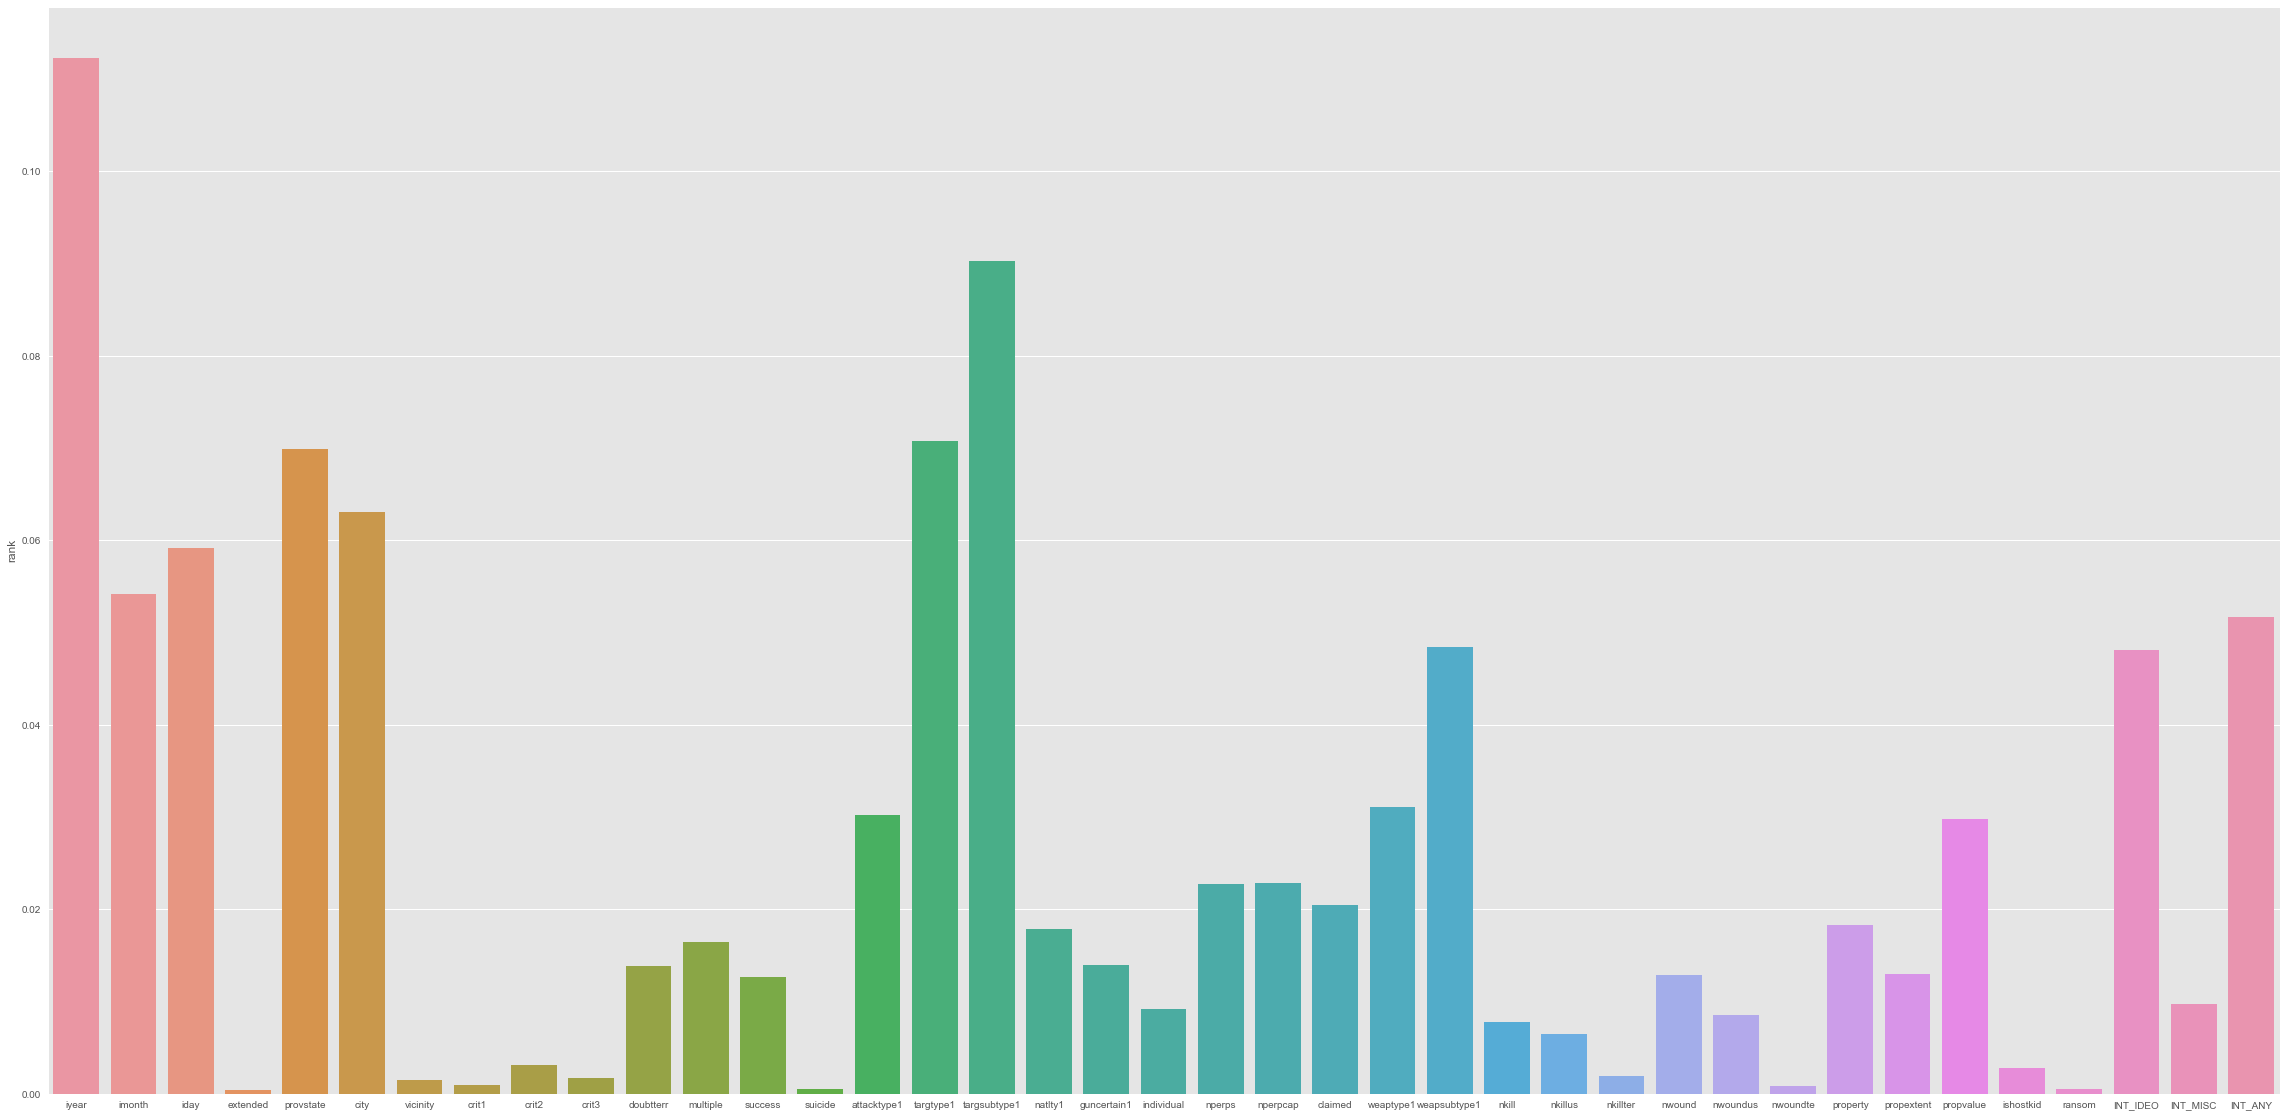

In [34]:
plt.figure(figsize=(40,20)) # this creates a figure 8 inch wide, 4 inch high
sns.barplot(x = X.columns, y = 'rank',  data = feature_rank, order = X.columns )
plt.show()

In [35]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.15
sfm = SelectFromModel(clf, threshold=0.020)

In [36]:
# Train the selector
sfm.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
        norm_order=1, prefit=False, threshold=0.02)

In [37]:
# Print the names of the most important features
for feature_list_index in sfm.get_support(indices=True):
    print(X.columns[feature_list_index])


iyear
imonth
iday
provstate
city
attacktype1
targtype1
targsubtype1
nperps
nperpcap
claimed
weaptype1
weapsubtype1
propvalue
INT_IDEO
INT_ANY


***Create A Data Subset With Only The Most Important Features***


In [38]:
# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

***Train A New Random Forest Classifier Using Only Most Important Features***


In [39]:
# Create a new random forest classifier for the most important features
clf_important = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

# Train the new classifier on the new dataset containing the most important features
clf_important.fit(X_important_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

***Compare The Accuracy Of Our Full Feature Classifier To Our Limited Feature Classifier***


In [40]:
# Apply The Full Featured Classifier To The Test Data
y_pred = clf.predict(X_test)

# View The Accuracy Of Our Full Feature Model
accuracy_score(y_test, y_pred)

0.66591166477916197

In [41]:
# Apply The Full Featured Classifier To The Test Data
y_important_pred = clf_important.predict(X_important_test)

# View The Accuracy Of Our Limited Feature Model
accuracy_score(y_test, y_important_pred)

0.65911664779161949

In [42]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
dtree = dtree.fit(X_train, y_train)
dtree.score(X_train, y_train)

1.0

This is a classic example of Overfitting where the trained model is tested on the same dataset, achieveing 100% accurracy; but achieving much less than that when tested using the test model (about 66% accuracy). This means the trained dataset cannot generalize well to an out of sample dataset. There are ways to fix this. One of these is feature engineering which requires domain knowledge. This can be used to reduce the number of classes or labels to a point where required generalization is attained 

Barely looking at the unique classes for gname, we see that there are 228 unique labels for a dataset of 2206 observations. This by advice, is way too much. This is probably the cause of the unnecessary overfitting. Feature engineering can fix this by combining labels and re-categorizing same. 

In [43]:
len(y.unique())

228

I will prove this using another categorical feature 'INT_IDEO', which is categorical variable that specifies:
1 = "Yes"    for nationality of attack group different from the location of the attack
0 = "No"     for nationality of attack group same as the location of the attack
-9 = "Unknown" nationality of the attack group is unknown

In [44]:
W = df9.drop('INT_IDEO', axis=1)
z = df9['INT_IDEO']

In [45]:
len(z.unique())

3

In [46]:
# Split the data into 40% test and 60% training
W_train, W_test, z_train, z_test = train_test_split(W, z, test_size=0.4, random_state=0)

In [47]:
# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

In [48]:
# Train the classifier
clf.fit(W_train, z_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [49]:
# Print the name and gini importance of each feature
for feature in zip(W.columns, clf.feature_importances_):
    print(feature)

('iyear', 0.075126582684669652)
('imonth', 0.016435634597923254)
('iday', 0.019102332718381767)
('extended', 9.5902998925248052e-05)
('provstate', 0.022477726021796873)
('city', 0.022825444744968351)
('vicinity', 0.00054876594890211541)
('crit1', 0.00029047640940950902)
('crit2', 0.0010320981132470525)
('crit3', 0.00073518534912244218)
('doubtterr', 0.0069395446007365453)
('multiple', 0.0035772557181076021)
('success', 0.0030394858495327798)
('suicide', 0.00032434256377497509)
('attacktype1', 0.021899881174470004)
('targtype1', 0.029264641544780749)
('targsubtype1', 0.036624522749895361)
('natlty1', 0.026493261442104656)
('gname', 0.099215975302178877)
('guncertain1', 0.0047229458895094827)
('individual', 0.034350271984359394)
('nperps', 0.0092012822292822719)
('nperpcap', 0.0090948968091856073)
('claimed', 0.017037242195383478)
('weaptype1', 0.016804670625508007)
('weapsubtype1', 0.034994780709484315)
('nkill', 0.0020920382042815214)
('nkillus', 0.0022484738015376014)
('nkillter', 0.0

In [50]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.15
sfm = SelectFromModel(clf, threshold=0.020)

In [51]:
# Train the selector
sfm.fit(W_train, z_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
        norm_order=1, prefit=False, threshold=0.02)

In [52]:
# Print the names of the most important features
for feature_list_index in sfm.get_support(indices=True):
    print(W.columns[feature_list_index])

iyear
provstate
city
attacktype1
targtype1
targsubtype1
natlty1
gname
individual
weapsubtype1
INT_MISC
INT_ANY


In [53]:
# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
W_important_train = sfm.transform(W_train)
W_important_test = sfm.transform(W_test)

In [54]:
# Create a new random forest classifier for the most important features
clf_important = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

# Train the new classifier on the new dataset containing the most important features
clf_important.fit(W_important_train, z_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [55]:
# Apply The Full Featured Classifier To The Test Data
y_pred = clf.predict(W_test)

# View The Accuracy Of Our Full Feature Model
accuracy_score(z_test, y_pred)

0.970554926387316

In [56]:
# Apply The Full Featured Classifier To The Test Data
y_important_pred = clf_important.predict(W_important_test)

# View The Accuracy Of Our Limited Feature Model
accuracy_score(z_test, y_important_pred)

0.97961494903737256

In [57]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
dtree = dtree.fit(W_train, z_train)
dtree.score(W_train, z_train)

1.0

So, we can see the importance of limiting the number of classes in the target. Having just 3 labels achieved 98% with the important predictors, which is close to the training model of 100%. This generalizes well compared with having so many classes in the prediction analysis of 'gname'. 

There are no rule of thumb for number of labels one should have has target variables. It all depends on business needs and how much errors one can stomach. This proves that re-engineering 'gname' and regrouping into lesser classes will improve generalization from training model to testing model. 